In [11]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Load Data

In [229]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Exploratory Data Analysis


### Overview


In [3]:
# Overview of the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [4]:
# Display the first few rows
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [5]:
# Numerical features
X.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
# Categorical features
X.describe(include=['object', 'category'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,44923,45211,43354,45211,45211,45211,32191,45211,8252
unique,11,3,3,2,2,2,2,12,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure
freq,9732,27214,23202,44396,25130,37967,29285,13766,4901


### Target Variable

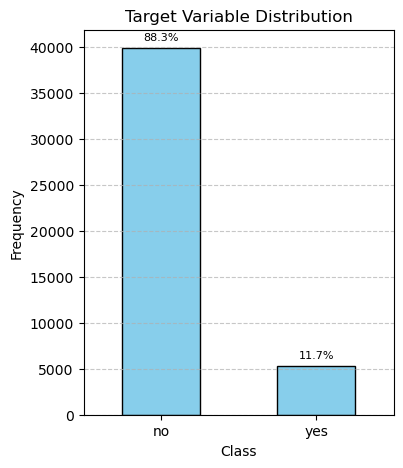

In [31]:
# Calculate value counts and percentage distribution
class_counts = y['y'].value_counts()
class_distribution = class_counts / class_counts.sum() * 100

# Create a bar plot
plt.figure(figsize=(4, 5))
ax = class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add percentage labels on top of bars
for i, v in enumerate(class_counts):
    percentage = class_distribution.iloc[i]
    ax.text(i, v + 0.02 * max(class_counts), f'{percentage:.1f}%',
            ha='center', fontsize=8, color='black')

# Formatting the plot
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep class labels readable
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Numerical Features

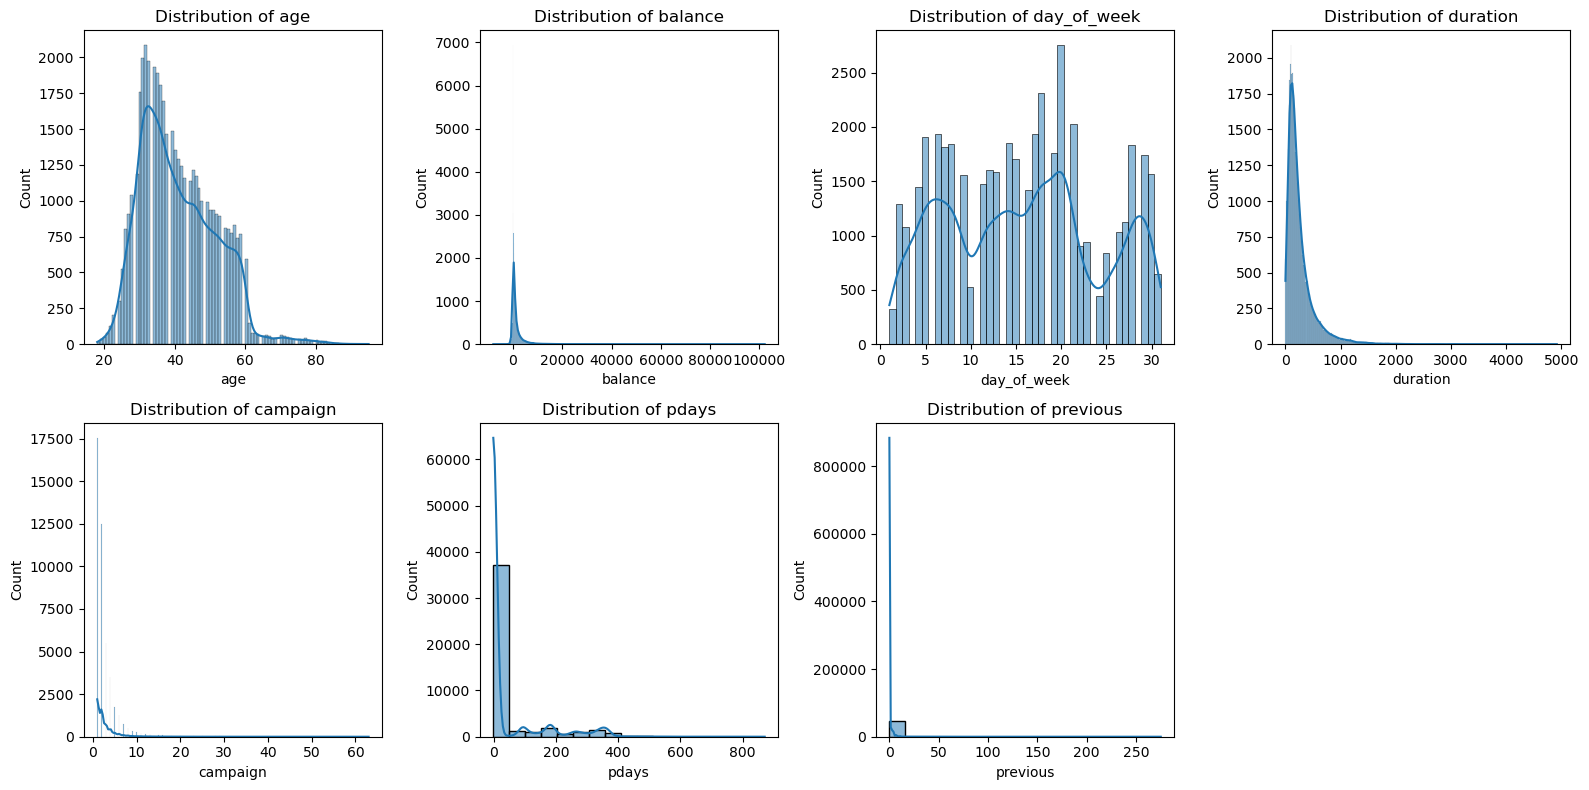

In [ ]:
# Select numerical columns
numerical_cols = X.select_dtypes(include=['int64']).columns

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Plot each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(X[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide the empty subplot if fewer than 8 plots
for j in range(i + 1, 8):
    fig.delaxes(axes[j])

# Show the plot
plt.tight_layout()
plt.show()

### Categorical Features

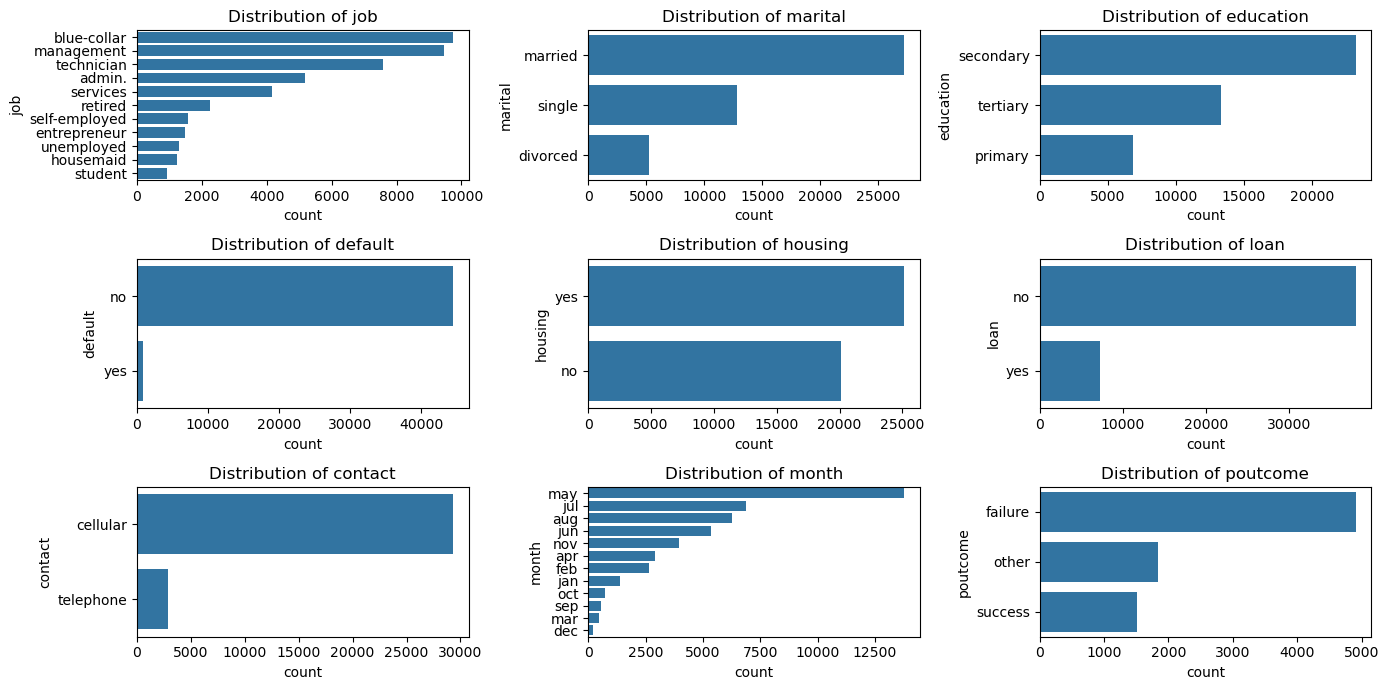

In [258]:
# Select categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
axes = axes.flatten()

# Plot each categorical column
for i, col in enumerate(categorical_cols):
    sns.countplot(X[col], ax=axes[i], order=X[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')

# Show the plot
plt.tight_layout()
plt.show()

# Data Cleaning


### Handle Missing Values


<Axes: >

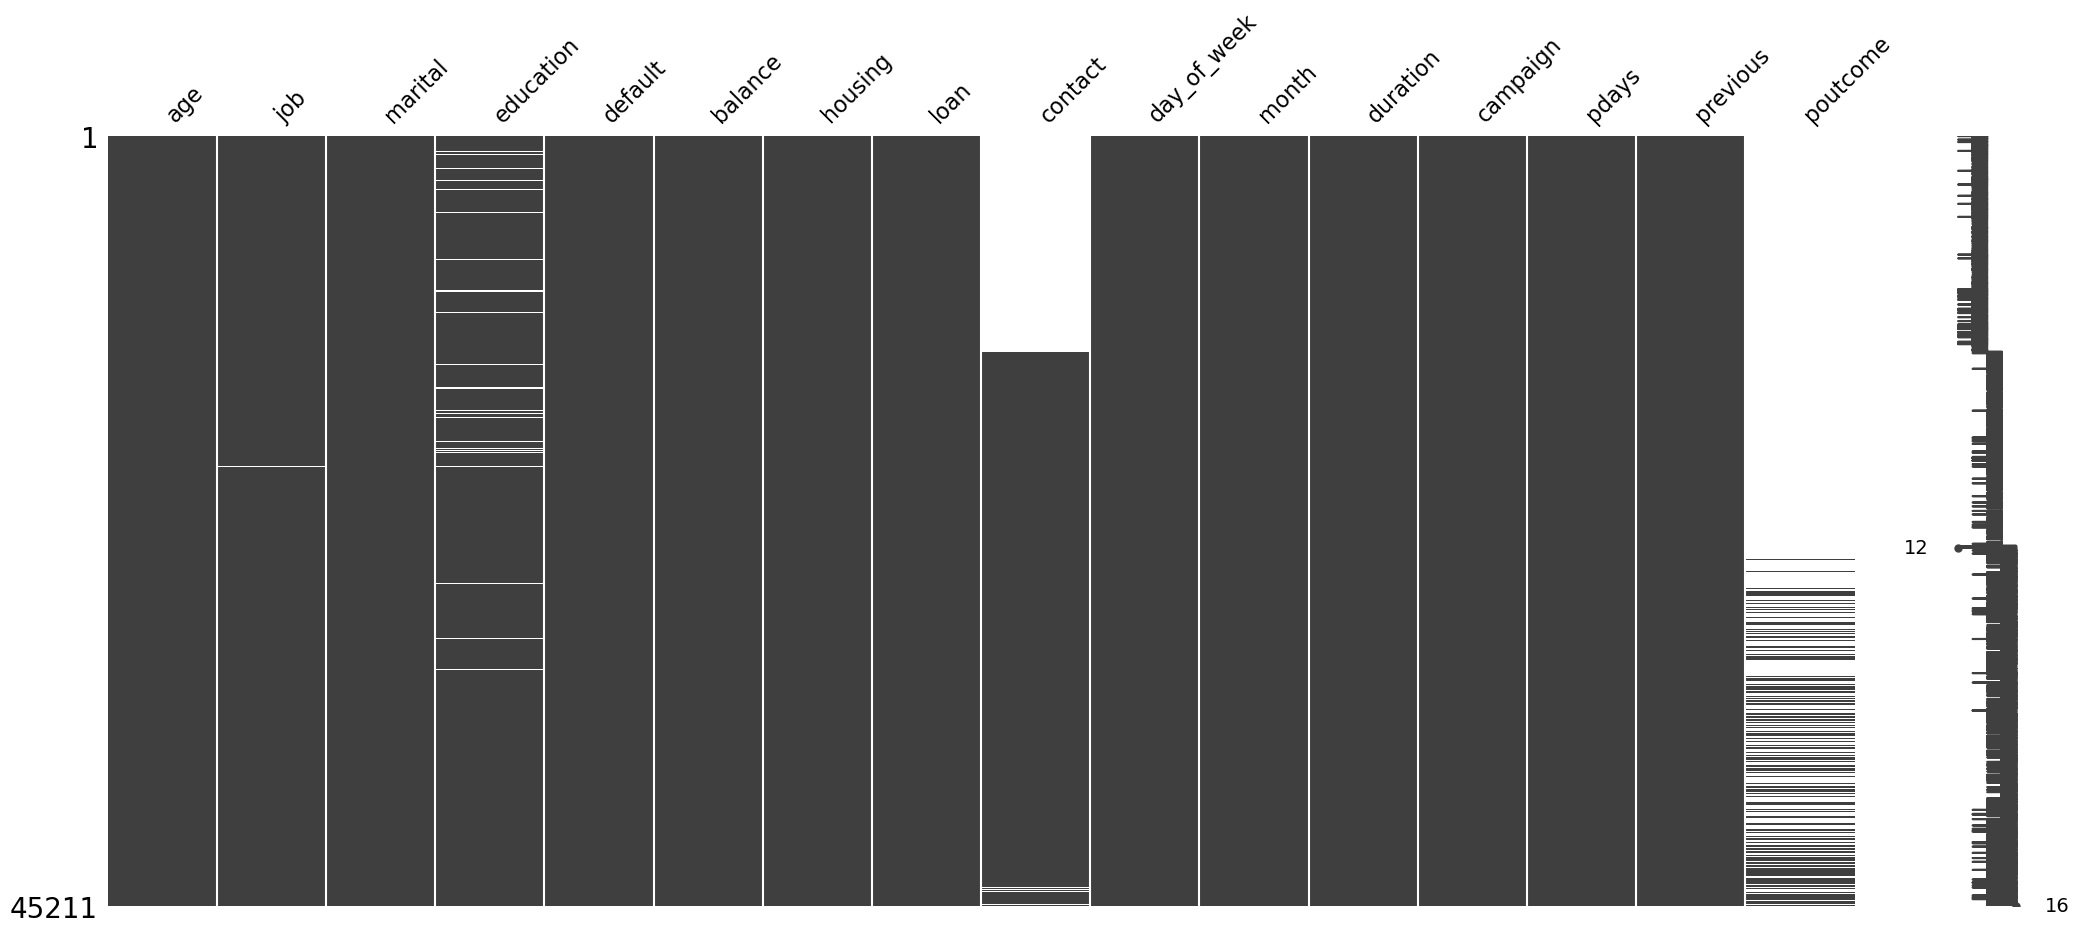

In [267]:
# Visualize missing values
msno.matrix(X)

In [ ]:
# Exact number of missing values
X.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

The dataset contains missing values in four features: `job`, `education`, `contact`, and `poutcome`. Here are the techniques that will be used to handle the missing values:
1) Due to the high proportion of missing values in `contact` and `poutcome`, these features will be dropped to maintain data integrity.
2) In contrast, `job` and `education` have missing values in less than 10% of the dataset, making them suitable for imputation.
3) The **k-Nearest Neighbors Imputer (kNNImputer)** from **scikit-learn** will be used to fill in the missing values for `education` and `job` based on similar observations.
4) Since **kNNImputer** requires numerical inputs, categorical features will be converted into their numerical representations as follows:
    * `education` and `job` will be encoded using **LabelEncoder** since the the imputation will only be carried out for these features.
    * `marital`, and `month` will be encoded using **OneHotEncoding** since there are no ordinal relationships within the data.
    * `default`, `housing`, and `loan` will simply be encoded into their binary representations (i.e. yes-1, no-0)

In [230]:
# Create a copy of X for cleaning
X_clean = X.copy()

In [231]:
# Drop `contact` and `poutcome`
X_clean.drop(['contact','poutcome'],axis=1,inplace=True)
X_clean.head()

,age,job,marital,education,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,5,may,92,1,-1,0
4,33,NaN,single,NaN,no,1,no,no,5,may,198,1,-1,0


In [232]:
# Initialize LabelEncoders - one for each feature to store mapping
le_education = LabelEncoder()
le_job = LabelEncoder()

# Converting non-numeric features to numeric (NaN values will remain NaN)
X_clean['education_transform'] = le_education.fit_transform(X_clean['education'].astype(str))
X_clean['job_transform'] = le_job.fit_transform(X_clean['job'].astype(str))

# Change NaN labels back into np.nan
X_clean['education_transform'] = X_clean['education_transform'].replace(0,np.nan)
X_clean['job_transform'] = X_clean['job_transform'].replace(5,np.nan)

# Change 11 to 5 since the nan value took the value of 5 during encoding (this ensures that the imputation wouldn't accidently assign nan values)
X_clean['job_transform'] = X_clean['job_transform'].replace(11,5)

# Display the encoded values
X_clean[['education', 'education_transform', 'job', 'job_transform']].head()

,education,education_transform,job,job_transform
0,tertiary,3.0,management,4.0
1,secondary,2.0,technician,10.0
2,secondary,2.0,entrepreneur,2.0
3,NaN,NaN,blue-collar,1.0
4,NaN,NaN,NaN,NaN


In [233]:
# One-Hot Encoding
X_clean = pd.get_dummies(X_clean, columns=['marital','month'], drop_first=False, dtype=float)
X_clean.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'education_transform', 'job_transform', 'marital_divorced',
       'marital_married', 'marital_single', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object')

In [234]:
# Transform binary features
X_clean['default_transform'] = X_clean['default'].map({'yes': 1, 'no': 0})
X_clean['housing_transform'] = X_clean['housing'].map({'yes': 1, 'no': 0})
X_clean['loan_transform'] = X_clean['loan'].map({'yes': 1, 'no': 0})

# Display the binary transformation
X_clean[['default','default_transform','housing','housing_transform','loan','loan_transform']].head()

,default,default_transform,housing,housing_transform,loan,loan_transform
0,no,0,yes,1,no,0
1,no,0,yes,1,no,0
2,no,0,yes,1,yes,1
3,no,0,yes,1,no,0
4,no,0,no,0,no,0


Now that all features have been successfully converted into numerical representations—either through **Label Encoding**, **One-Hot Encoding**, or by transforming boolean values into binary format—we can proceed with the imputation process. Begin by scaling the data to ensure that all feature contribute equally to the imputation process.

In [235]:
# Select features that could be relevant to job for imputation
features_for_imputation = [
    'age',
    'balance',
    'day_of_week',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'education_transform',
    'job_transform',
    'marital_divorced',
    'marital_married',
    'marital_single',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_sep',
    'month_oct',
    'month_nov',
    'month_dec',
    'default_transform',
    'housing_transform',
    'loan_transform'
]

# Dataframe with selected features
X_clean_subset = X_clean[features_for_imputation]

# Scale the data
scaler = MinMaxScaler()
X_clean_subset_scaled = pd.DataFrame(scaler.fit_transform(X_clean_subset), columns=X_clean_subset.columns)

# Display scaled data subset
X_clean_subset_scaled

,age,balance,day_of_week,duration,campaign,pdays,previous,education_transform,job_transform,marital_divorced,...,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,default_transform,housing_transform,loan_transform
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,1.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,0.5,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,NaN,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,0.0,0.6,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,0.5,0.6,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,0.5,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Next, proceed with the `KNNImputer`. Compare missing values from before and after imputation.

Before:

In [236]:
# Before imputation
X[['job','education']].head()

,job,education
0,management,tertiary
1,technician,secondary
2,entrepreneur,secondary
3,blue-collar,NaN
4,NaN,NaN


After:

In [237]:
# Initialize KNNImputer (use n_neighbors=5 by default or any other number of neighbors)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

# Perform KNN Imputation (fit and transform the data)
X_imputed = imputer.fit_transform(X_clean_subset_scaled)

# Inverse transform
X_imputed = scaler.inverse_transform(X_imputed)

# Convert imputed data back into a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=features_for_imputation)

# Round the imputed job values to the nearest integer (as job is categorical)
X_imputed['education_transform'] = np.round(X_imputed['education_transform']).astype(int)
X_imputed['job_transform'] = np.round(X_imputed['job_transform']).astype(int)

# Display the imputed values
X_imputed[['job_transform','education_transform']].head()

# Inverse transform the LabelEncoder values
imputed_job = le_job.inverse_transform(X_imputed['job_transform'].head())
imputed_education = le_education.inverse_transform(X_imputed['education_transform'].head())

# Format into dataframe
imputed_after = pd.DataFrame({'job_transform': imputed_job, 'education_transform': imputed_education})

# Replace 'nan' with 'unemployed' since we changed 11 to 5 previously during encoding
imputed_after['job_transform'] = imputed_after['job_transform'].replace('nan','unemployed')

# Display values after imputation
imputed_after

,job_transform,education_transform
0,management,tertiary
1,technician,secondary
2,entrepreneur,secondary
3,blue-collar,primary
4,unemployed,secondary


Final check for missing values:

In [238]:
X_imputed.isnull().sum()

age                    0
balance                0
day_of_week            0
duration               0
campaign               0
pdays                  0
previous               0
education_transform    0
job_transform          0
marital_divorced       0
marital_married        0
marital_single         0
month_jan              0
month_feb              0
month_mar              0
month_apr              0
month_jun              0
month_jul              0
month_aug              0
month_sep              0
month_oct              0
month_nov              0
month_dec              0
default_transform      0
housing_transform      0
loan_transform         0
dtype: int64

# Feature Engineering


In [240]:
# Convert target y into binary integers
y_clean = y.copy()
y_clean['y_integer'] = y_clean['y'].map({'yes': 1, 'no': 0})
print(y_clean['y_integer'].value_counts(normalize=True))

y_integer
0    0.883015
1    0.116985
Name: proportion, dtype: float64


## Handle imbalanced target variable


In [241]:
# SMOTE (Synthetic Minority Oversampling Technique)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_clean['y_integer'])

print(f"Class distribution after resampling: {np.bincount(y_resampled)}")

Class distribution after resampling: [39922 39922]


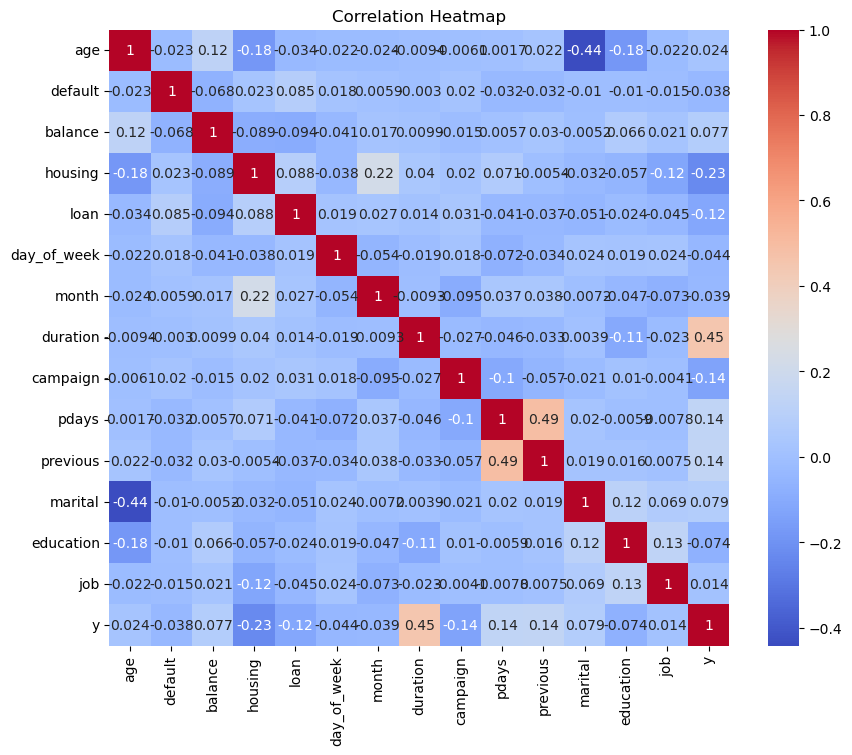

In [15]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = pd.concat([X_resampled, y_resampled], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Tree-Based Feature Importance


                Feature  Importance
3              duration    0.246761
24    housing_transform    0.129209
10      marital_married    0.073918
11       marital_single    0.062345
1               balance    0.039683
0                   age    0.038874
2           day_of_week    0.038280
5                 pdays    0.037819
6              previous    0.035095
15            month_apr    0.031255
4              campaign    0.030987
18            month_aug    0.030884
8         job_transform    0.023914
25       loan_transform    0.023908
17            month_jul    0.022839
9      marital_divorced    0.020480
14            month_mar    0.019797
16            month_jun    0.019655
20            month_oct    0.019394
13            month_feb    0.013011
21            month_nov    0.012020
19            month_sep    0.011474
7   education_transform    0.009279
12            month_jan    0.005152
22            month_dec    0.002858
23    default_transform    0.001109


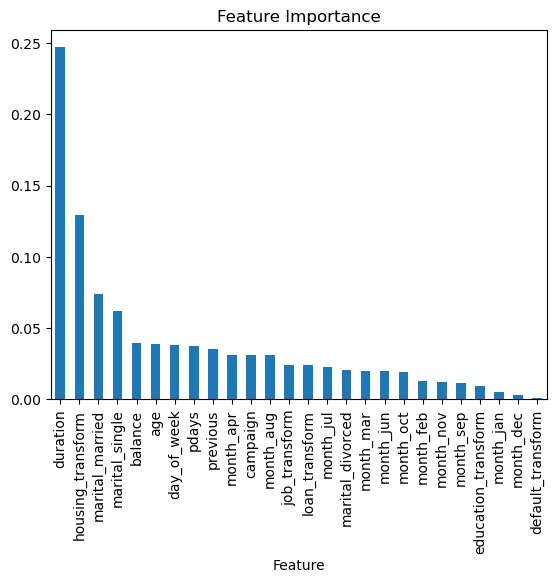

In [242]:
# Train a simple model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Visualize feature importance
feature_importances.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.show()

In [243]:
# Drop irrelevant features
X_resampled = X_resampled.drop(['duration'],axis=1)

## Split the data into training and testing sets


In [244]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (63875, 25)
X_test shape: (15969, 25)
y_train shape: (63875,)
y_test shape: (15969,)


## Train and evaluate models

### Logistic Regression


In [245]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg, pos_label=1):.4f}")

Logistic Regression Performance:
Accuracy: 0.6347
Precision: 0.6702
Recall: 0.5441
F1 Score: 0.6006


/Users/Anaqi_Amir/opt/anaconda3/envs/bank_marketing/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Classifier


In [246]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, pos_label=1):.4f}")

Random Forest Performance:
Accuracy: 0.9316
Precision: 0.9663
Recall: 0.8957
F1 Score: 0.9296


### XGBoost Classifier


In [247]:
# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb, pos_label=1):.4f}")


XGBoost Performance:
Accuracy: 0.9327
Precision: 0.9722
Recall: 0.8922
F1 Score: 0.9305


## Cross Validation


In [248]:
# Perform cross-validation on Random Forest
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"RandomForestClassifier Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC_AUC Score: {cv_scores.mean():.4f}")

# Perform cross-validation on XGBoost
cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')
print(f"XGBoost Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC_AUC Score: {cv_scores.mean():.4f}")

RandomForestClassifier Cross-Validation ROC-AUC Scores: [0.97094075 0.97261803 0.97087398 0.97101577 0.97008982]
Mean ROC_AUC Score: 0.9711
XGBoost Cross-Validation ROC-AUC Scores: [0.96968762 0.97061305 0.96976708 0.97028703 0.96780541]
Mean ROC_AUC Score: 0.9696


In [249]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Shrinkage rate
    'max_depth': [3, 5, 7, 10],                 # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],               # Fraction of samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0],        # Fraction of features for each tree
    'gamma': [0, 1, 5],                         # Minimum loss reduction for split
    'reg_alpha': [0, 0.1, 1],                   # L1 regularization
    'reg_lambda': [1, 2, 5],                    # L2 regularization
}

xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=50,            # Number of parameter settings sampled
    scoring='f1_macro',   # Evaluation metric
    cv=5,                 # 5-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1             # Use all available cores
)

# Fit to training data
xgb_random_search.fit(X_train, y_train)

# Display best parameters
print(f"Best Parameters: {xgb_random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      7908
           1       0.97      0.90      0.93      8061

    accuracy                           0.93     15969
   macro avg       0.94      0.93      0.93     15969
weighted avg       0.94      0.93      0.93     15969

ROC-AUC Score: 0.9680


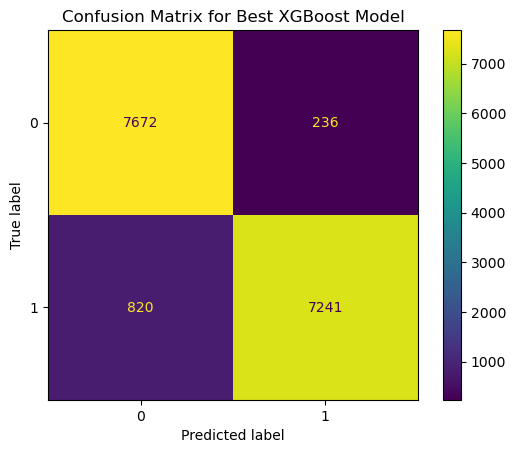

In [250]:
# Retrieve the best model
best_xgb = xgb_random_search.best_estimator_

# Predict on test data
y_pred_best_xgb = best_xgb.predict(X_test)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test, y_pred_best_xgb))

# Compute ROC-AUC
y_pred_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_best_xgb)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("Confusion Matrix for Best XGBoost Model")
plt.show()

In [42]:
# Save the model
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
print("Best XGBoost Model Saved!")

Best XGBoost Model Saved!


<Figure size 1000x800 with 0 Axes>

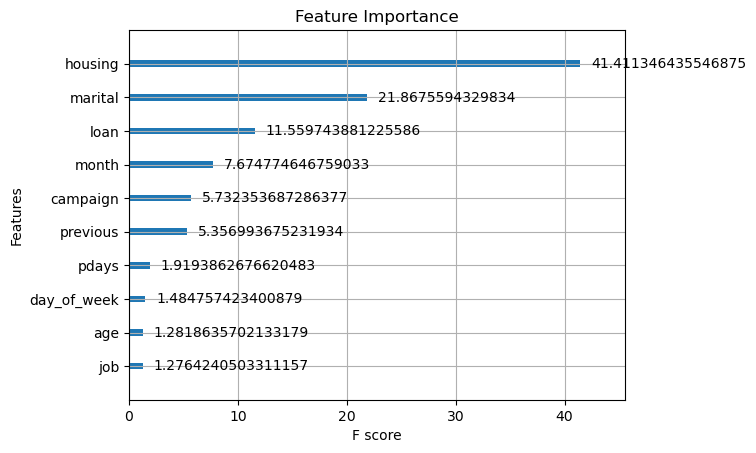

In [44]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, max_num_features=10, importance_type='gain')  # Top 10 features
plt.title('Feature Importance')
plt.show()